Our plan is to use the tournament seeds as a predictor of tournament performance. 
We will train a logistic regressor on the difference in seeding between the two teams playing, and have the result of the game as the desired output

This is inspired by [last years competition][1], where [Jared Cross made a model just based on the team seeds][2].


  [1]: https://www.kaggle.com/c/march-machine-learning-mania-2016
  [2]: https://www.kaggle.com/jaredcross/march-machine-learning-mania-2016/getting-started

In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["dir", "/b", "/a-d","MMolddata"], shell=True).decode("utf8"))

# Any results you write to the current directory are saved as output.

RegularSeasonCompactResults.csv
RegularSeasonDetailedResults.csv
SampleSubmission.csv
Seasons.csv
Teams.csv
TourneyCompactResults.csv
TourneyDetailedResults.csv
TourneySeeds.csv
TourneySlots.csv



## Load the training data ##
We are just having a look at the format of the training data to make sure that it looks like we expect

In [30]:
data_dir = 'MMolddata/'
df_seeds = pd.read_csv(data_dir + 'TourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'TourneyCompactResults.csv')

In [31]:
df_seeds.head()

,Season,Seed,Team
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [32]:
df_tour.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


Let's drop the columns we are not planning on using

In [33]:
df_tour.drop(labels=['Daynum', 'Wscore', 'Lscore', 'Wloc', 'Numot'], inplace=True, axis=1)
df_tour.head()

,Season,Wteam,Lteam
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


Get the seeds as integers

In [34]:
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_seeds['n_seed'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label
df_seeds.head()

,Season,Team,n_seed
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


## Merge seed for each team ##
We want the seeds in the same DataFrame as the game results

In [35]:
df_winseeds = df_seeds.rename(columns={'Team':'Wteam', 'n_seed':'win_seed'})
df_lossseeds = df_seeds.rename(columns={'Team':'Lteam', 'n_seed':'loss_seed'})

In [36]:
df_winseeds.head()

,Season,Wteam,win_seed
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [37]:
df_lossseeds.head()

,Season,Lteam,loss_seed
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [38]:
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'Wteam'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'Lteam'])
df_concat['seed_diff'] = df_concat.win_seed - df_concat.loss_seed

In [39]:
df_dummy.head()

,Season,Wteam,Lteam,win_seed
0,1985,1116,1234,9
1,1985,1120,1345,11
2,1985,1207,1250,1
3,1985,1229,1425,9
4,1985,1242,1325,3


In [40]:
df_concat.shape

(2050, 6)

## Make a new DF with just the wins and losses ##

In [41]:
df_wins = pd.DataFrame()
df_wins['seed_diff'] = df_concat['seed_diff']
df_wins['result'] = 1

df_losses = pd.DataFrame()
df_losses['seed_diff'] = -df_concat['seed_diff']
df_losses['result'] = 0

df_for_predictions = pd.concat((df_wins, df_losses))


In [42]:
df_for_predictions.shape

(4100, 2)

In [43]:
# Crosstab table of seed_diff vs result
result_seed_diff = pd.crosstab(index=df_for_predictions["result"], 
                           columns=df_for_predictions["seed_diff"],
                              margins=True)

result_seed_diff.index= ["loss","win", 'nan']

result_seed_diff

seed_diff,-15,-13,-12,-11,-10,-9,-8,-7,-6,-5,...,6,7,8,9,10,11,12,13,15,All
loss,0,8,0,21,3,28,55,64,6,70,...,10,145,166,120,4,126,5,120,128,2050
win,128,120,5,126,4,120,166,145,10,155,...,6,64,55,28,3,21,0,8,0,2050
nan,128,128,5,147,7,148,221,209,16,225,...,16,209,221,148,7,147,5,128,128,4100


In [44]:
X_train = df_for_predictions.seed_diff.values.reshape(-1,1)
X_train

array([[  1],
       [  5],
       [-15],
       ..., 
       [  9],
       [  0],
       [ -1]], dtype=int64)

In [ ]:
y_train = df_for_predictions.result.values
X_train, y_train = shuffle(X_train, y_train)

## Train the estimator ##
We use logistic regression, so we have to set a `C` value. We can just try a bunch of different values and then choose the best one.

In [11]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5541, with best C: 0.01


## Examine the classifier predictions ##

In [12]:
X = np.arange(-16, 16).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

Text(0,0.5,'P(Team1 will win)')

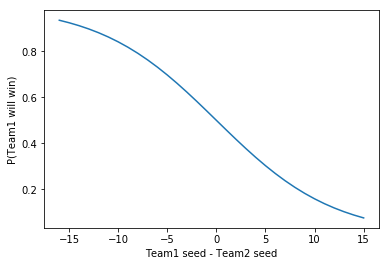

In [13]:
%matplotlib inline
plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

This looks like we would expect. We are predicting the probability of team1 winning. If that team has a lower seed than team2, there is a high probability of team1 winning.

## Get the test data ##

In [21]:
df_sample_sub = pd.read_csv(data_dir + 'SampleSubmission.csv')
n_test_games = len(df_sample_sub)
print(n_test_games)

2278


In [15]:
df_sample_sub.head()

,Id,Pred
0,2017_1112_1116,0.5
1,2017_1112_1124,0.5
2,2017_1112_1137,0.5
3,2017_1112_1139,0.5
4,2017_1112_1153,0.5


In [16]:
def get_year_t1_t2(id):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in id.split('_'))

We loop over each row in the `sample_submission.csv` file. For each row, we extract the year and the teams playing. 
We then look up the seeds for each of those teams *in that season*. 
Finally we add the seed difference to an array.

In [23]:
X_test = np.zeros(shape=(n_test_games, 1))
print(X_test)

[[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]


In [24]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.Id)
    # There absolutely must be a better way of doing this!
    t1_seed = df_seeds[(df_seeds.Team == t1) & (df_seeds.Season == year)].n_seed.values[0]
    t2_seed = df_seeds[(df_seeds.Team == t2) & (df_seeds.Season == year)].n_seed.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

## Make the predictions ##

In [29]:
preds = clf.predict_proba(X_test)[:,1]
print(preds)

[ 0.73101247  0.54156078  0.86210724 ...,  0.30298199  0.4174488
  0.62243177]


In [30]:
clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

,Id,Pred
0,2017_1112_1116,0.731012
1,2017_1112_1124,0.541561
2,2017_1112_1137,0.862107
3,2017_1112_1139,0.582551
4,2017_1112_1153,0.660721


## Save game predictions to .csv

In [20]:
df_sample_sub.to_csv('logreg_on_seed.csv', index=False)